# Исследование по движению цены индекса RTS, после первой свечи за торговую сессию с использованием фильтра в виде среднего первых свечей.

Фильтр среднего применяется в виде того, что учитываются первые свечи с открытия сессии тела которых больше среднего значения всех первых свечей.

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,12)  # Размер области построения
# %matplotlib qt  # Построенный график в отдельном окне

In [24]:
dir_source = Path('c:/data_finam_quote_csv')  # Папка откуда берем csv файлы для обработки
file_mask = 'SPFB.RTS_5min_*.csv'  # Маска файлов, которые обрабатываем

In [25]:
files_lst = list(dir_source.glob(file_mask))  # Создаем список файлов которые будем обрабатывать
# files_lst[0:5]  # Проверяем, что список файлов сформирован

In [26]:
df_up = pd.DataFrame()  # Задаем пустой df куда будем писать значения закрытия свечей после повышающейся свечи
df_down = pd.DataFrame()  # Задаем пустой df куда будем писать значения закрытия свечей после понижающейся свечи

In [27]:
def mean_first_candles():
    """
    Функция подсчитывает среднее значение для тел первых за сессию свечей
    """
    # Читаем в DF сводный файл
    df = pd.read_csv('c:/data_prepare_quote_csv/SPFB.RTS_5min.csv', delimiter=';', index_col='date_time')
    
    # Оставляем в DF только строки соответствующие открытию сесии (10:00)
    df = df.loc[df['time'] == 100000]
    
    # Создаем новое поле 'abs_body_candle' куда записываем модуль разницы открытия и закрытия свечи
    df['abs_body_candle'] = df.apply(lambda row: abs(row['open'] - row['close']), axis=1)  # axis=1 Указывает на колонку
    
    return df[['abs_body_candle']].mean()  # Возвращаем среднее

In [28]:
# среднее по всем первым свечам
candle_first_mean = float(mean_first_candles())

# В цикле обрабатываем список файлов
count_loop = 0
for file in files_lst:
    df = pd.read_csv(file, delimiter=',')  # Загружаем файл в DF
    
    # Дату в нужном формате строкой, она понадобиться для названия новой колонки с нормализованной ценой
    new_name_column = datetime.strptime(str(df.iat[0, 0]), '%Y%m%d').date()  # Дату в нужном формате строкой
    
    df = df.set_index(pd.to_datetime(df['<TIME>'], format='%H%M%S').dt.time)  # Меняем индекс и делаем его типом time
    
    # Берем самое первое по времени значение <CLOSE> к нему нормализуем цены <CLOSE> и заносим к новую колонку 
    # с датой в имени
    price_at_t0 = df.iloc[0, 5]  # Берем самое первое по времени значение (к нему нормализуем)
    df[new_name_column] = df.apply(lambda row: row['<CLOSE>'] / price_at_t0, axis=1)  # axis=1 Указывает на колонку
    
    if abs(df.iloc[0, 2] - df.iloc[0, 5]) > candle_first_mean:
        if df.iloc[0, 2] < df.iloc[0, 5]:  # Первая свеча на повышение (формируем df_up)

                df_up = df_up.join(df[new_name_column], how='outer')  # Join с объединением ключей
        else:
            df_down = df_down.join(df[new_name_column], how='outer')  # Join с объединением ключей
            
    
#     print(f'{candle_first_mean=} {df.iloc[0, 2]=} {df.iloc[0, 5]=}')
#     print(f'{abs(df.iloc[0, 2] - df.iloc[0, 5])}')
#     print()
    
#     if count_loop == 1:
#         break
#     count_loop += 1

df_up
# df

,2020-01-03,2020-02-04,2020-02-11,2020-02-12,2020-03-02,2020-03-04,2020-03-13,2020-03-17,2020-03-19,2020-03-20,...,2020-05-26,2020-06-01,2020-06-05,2020-06-19,2020-07-02,2020-07-06,2020-08-24,2020-10-01,2020-11-05,2020-11-09
<TIME>,,,,,,,,,,,,,,,,,,,,,
10:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
10:05:00,1.000000,1.000587,0.999409,0.998646,1.000149,1.002033,1.007731,1.001159,0.970367,0.988225,...,0.999428,0.998475,1.002606,1.001068,1.004650,1.001453,1.001490,0.997186,0.995410,1.000168
10:10:00,0.998531,0.999087,0.997570,1.003353,1.002234,1.002711,1.007319,1.007482,0.976439,0.989403,...,1.004087,0.993580,1.003080,1.004352,1.004982,1.001614,1.001725,0.997612,0.995234,1.004451
10:15:00,0.997127,0.999804,0.999212,1.003159,1.000149,1.000828,1.012164,1.008009,0.957372,0.985977,...,1.004904,0.994945,1.002132,1.004681,1.005065,1.001776,1.001490,0.999233,0.996028,1.006802
10:20:00,0.997510,1.000522,0.997176,1.001870,0.997915,1.001280,1.015565,1.012225,0.974375,0.985335,...,1.004414,0.997994,1.001501,1.005584,1.005397,1.000646,1.002275,0.996845,0.999912,1.004199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:25:00,0.991571,1.010372,1.008932,1.004771,0.986150,1.019280,1.085455,0.980188,1.084042,0.932349,...,0.992643,1.007623,1.005370,0.990638,1.013036,0.981757,1.004392,0.986527,1.032480,1.027628
23:30:00,0.992082,1.009850,1.008669,1.004707,0.987491,1.021389,1.076178,0.980188,1.082342,0.929137,...,0.991663,1.007703,1.004344,0.989571,1.013285,0.981757,1.004549,0.986783,1.030803,1.028300
23:35:00,0.992465,1.010111,1.009194,1.004900,0.990022,1.022443,1.074116,0.982506,1.078698,0.924641,...,0.992725,1.008747,1.004976,0.991377,1.013202,0.981272,1.004392,0.986442,1.029568,1.029476


In [29]:
df_down

,2020-01-21,2020-01-23,2020-01-27,2020-01-30,2020-02-13,2020-02-18,2020-02-25,2020-02-28,2020-03-10,2020-03-11,...,2020-06-11,2020-06-15,2020-06-25,2020-07-10,2020-07-30,2020-08-07,2020-09-17,2020-10-02,2020-10-30,2020-11-02
<TIME>,,,,,,,,,,,,,,,,,,,,,
10:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
10:05:00,1.000490,0.999938,1.000827,0.999098,1.001424,1.000719,1.000939,1.005736,0.996007,0.999359,...,0.996722,0.998376,0.996641,1.000496,0.997852,0.998903,1.001149,1.003323,0.994924,0.999331
10:10:00,1.000858,1.000623,0.999618,1.000258,1.001036,0.999020,1.002078,0.995094,1.011236,1.013281,...,0.996148,0.998547,0.995412,0.999504,0.998011,1.001253,1.001478,1.000000,0.990788,1.001625
10:15:00,1.000613,1.001183,1.000382,0.999742,1.001942,1.000131,1.002011,0.996981,1.027208,1.013372,...,0.997296,1.001624,0.997214,1.000579,0.994032,1.001802,1.003366,0.994578,0.992104,0.998375
10:20:00,1.000919,1.001370,1.000572,0.999807,1.000842,1.000261,1.001475,0.996453,1.016715,1.003023,...,0.998607,1.005129,0.997542,1.001240,0.991645,1.002428,1.001806,0.994053,0.991916,0.991685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:25:00,1.002144,0.999440,0.985566,0.998454,0.999871,0.996863,0.963191,0.992754,1.041322,0.957135,...,0.969024,1.029492,1.018843,1.018937,0.989815,0.995770,1.007142,1.001050,0.998214,1.025041
23:30:00,1.001286,0.999253,0.985248,0.998776,0.999482,0.997059,0.962454,0.993886,1.044480,0.956860,...,0.969516,1.029492,1.018106,1.019846,0.991725,0.995613,1.007963,1.001837,0.997932,1.025423
23:35:00,1.001041,0.999689,0.985058,0.999549,0.998705,0.995817,0.961716,0.993207,1.041415,0.958784,...,0.969516,1.029578,1.018352,1.019267,0.991964,0.996240,1.007880,1.001662,0.998120,1.024849


In [30]:
# Проверяем на пустые значения
print(df_up.isna().sum().sum())
print(df_down.isna().sum().sum())

10
46


In [31]:
# Заполняем NaN предыдущими значениями и опять проверяем
df_up.fillna(method='ffill', inplace=True)
df_down.fillna(method='ffill', inplace=True)
print(df_up.isna().sum().sum())
print(df_down.isna().sum().sum())

0
0


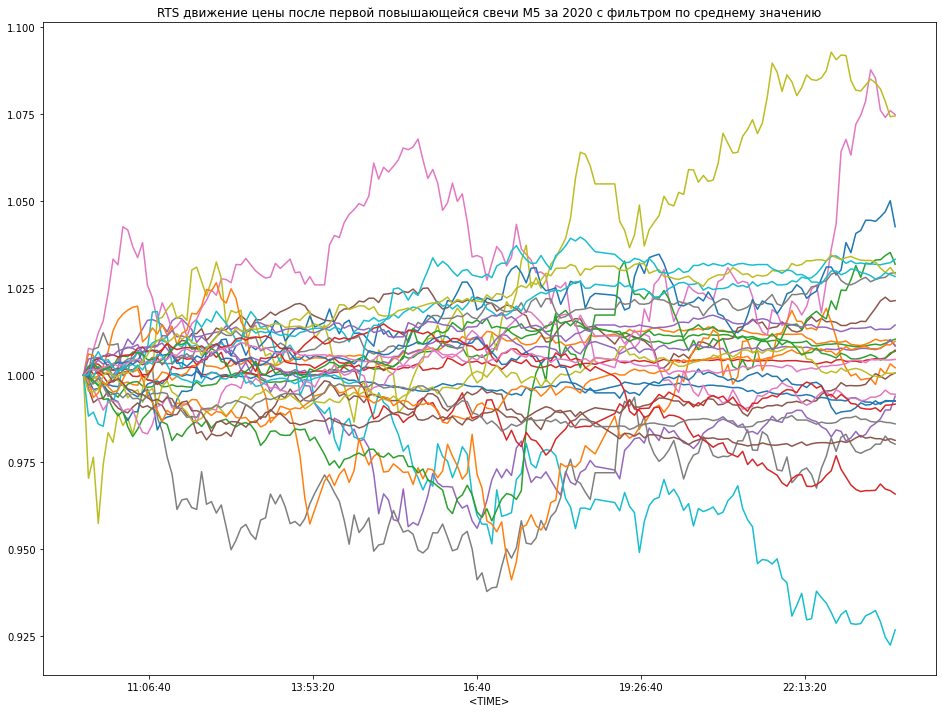

In [32]:
# Строим график
columns_lst_up = list(df_up.columns)
# print(columns_lst_up)

plt.title("RTS движение цены после первой повышающейся свечи М5 за 2020 с фильтром по среднему значению")
for column in columns_lst_up:
    df_up[column].plot()

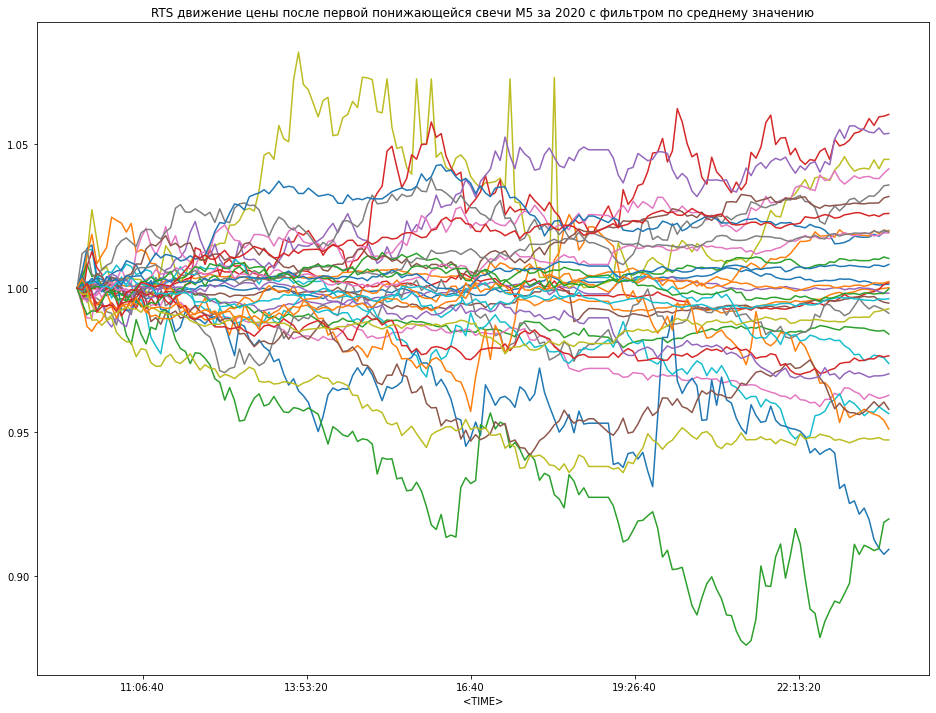

In [33]:
# Строим график
columns_lst_down = list(df_down.columns)  # Создаем список колонок dataframe df_down
# print(columns_lst_down)

plt.title("RTS движение цены после первой понижающейся свечи М5 за 2020 с фильтром по среднему значению")
for column in columns_lst_down:
    df_down[column].plot()